In [1]:
library(tidyverse)
library(ggplot2)
library(ggpubr)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.4.4     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'ggpubr' was built under R version 4.3.1"


In [2]:
score_b6 <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/TAD/version_0912/raw_intra_prop_B6_112.csv") %>% rename(index = '...1') 
score_cast <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/TAD/version_0912/raw_intra_prop_Cast_112.csv") %>% rename(index = '...1') 

New names:
* `` -> `...1`
Rows: 112 Columns: 905
-- Column specification --------------------------------------------------------
Delimiter: ","
dbl (905): ...1, d0A1, d0A10, d0A11, d0A12, d0A13, d0A14, d0A15, d0A16, d0A1...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
* `` -> `...1`
Rows: 112 Columns: 905
-- Column specification --------------------------------------------------------
Delimiter: ","
dbl (905): ...1, d0A1, d0A10, d0A11, d0A12, d0A13, d0A14, d0A15, d0A16, d0A1...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
my_tad <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/TAD/new_version/my_tad_filtered_mod_tadE_new.csv") %>% select(-index) %>% rename(index = `...1`)

New names:
* `` -> `...1`
Rows: 112 Columns: 6
-- Column specification --------------------------------------------------------
Delimiter: ","
dbl (6): ...1, index, start, end, distance, mask

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


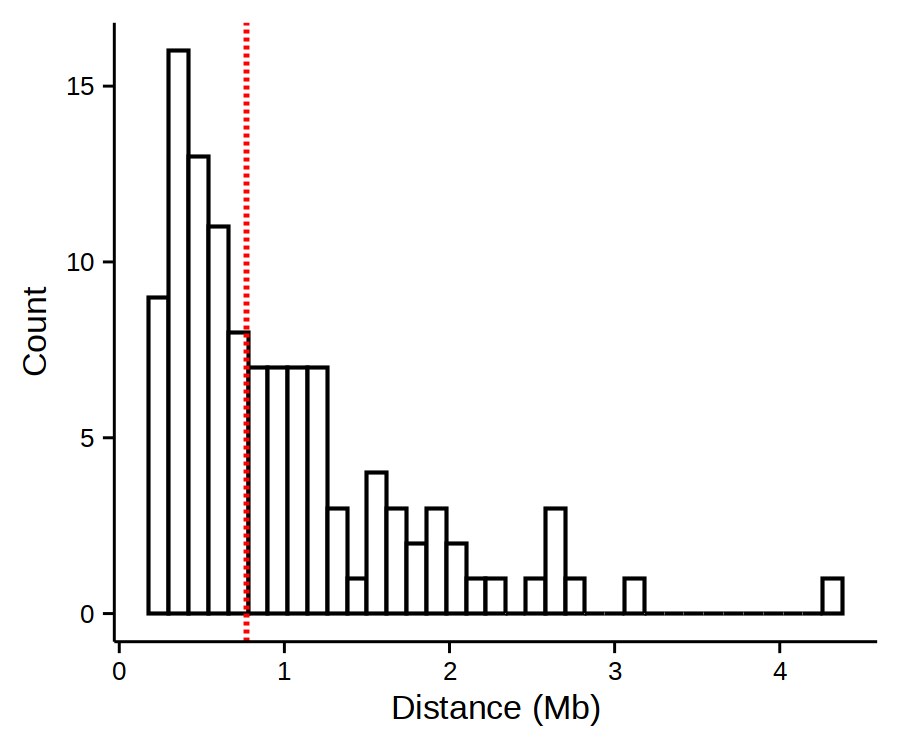

In [28]:
options(repr.plot.width=3,repr.plot.height=2.5,repr.plot.res=300)
p <- ggplot(my_tad, aes(x = distance*20000/1000000)) +
  geom_histogram(bins = 35, fill = "white", color = "black", linewidth = 0.35) +
  geom_vline(aes(xintercept = median(distance*20000/1000000)), color = "red", linetype = "dashed") +
  xlab("Distance (Mb)") + ylab("Count") + theme_classic()  + 
      theme(legend.position = "top",
      text = element_text(family="Arial", size=6),
      panel.border = element_blank(),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.background = element_blank(),
      axis.line = element_line(color="black", linewidth = 0.25),
      axis.ticks = element_line(color="black", linewidth = 0.25),
      axis.text = element_text(color="black",size=6),
      legend.key = element_rect(colour = NA),
      legend.key.width = unit(0.4, "cm"),
      legend.key.height = unit(0.4, "cm"),
      axis.title=element_text(color="black",size=8,face="plain"),
  )
p
ggsave("/share/Data/hxie/project/202209/esc_xwliu/figures_0827/supp/fig3C_tad_distance.svg", width = 3, height = 2.5, units = "in", dpi = 300)

In [4]:
my_tad %>% filter(start == 5173)

index,start,end,distance,mask
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
110,5173,5185,12,12


In [5]:
my_tad <- my_tad %>% mutate(dist = abs((start+end)/2 - 5173))

In [6]:
score_b6 <- score_b6 %>% filter(!index %in% c(109,110)) 
score_cast <- score_cast %>% filter(!index %in% c(109,110)) 

In [7]:
my_tad %>% pull(distance) %>% summary()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  12.00   23.00   38.50   49.70   62.25  216.00 

In [7]:
metadata <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc1014_halfday/RNA_analysis/s1014_metadata_X_noM_Xistneg_remain.csv")

Rows: 1029 Columns: 17
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (6): orig.ident, sample2, sample3, cellcycle_threshold, day, cellname
dbl (11): nCount_RNA, nFeature_RNA, nCount_SCT, nFeature_SCT, SCT_snn_res.1....

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
score_b6 <- score_b6 %>% column_to_rownames("index") %>% t() %>% na.omit() %>% t() %>% as.data.frame() %>% rownames_to_column("index")
score_cast <- score_cast %>% column_to_rownames("index") %>% t() %>% na.omit() %>% t() %>% as.data.frame() %>% rownames_to_column("index")

In [12]:
test_plot <- score_b6 %>% left_join(my_tad %>% select(index, dist) %>% mutate(index = as.character(index))) %>% pivot_longer(!c("index", "dist"), names_to = "cellname") %>% left_join(metadata %>% select(cellname, plot_cluster)) %>% 
    mutate(type = ifelse(dist < 100, "<2Mb",">2Mb")) %>% 
    mutate(type = factor(type, levels = c("<2Mb",">2Mb"))) %>%
    group_by(type) %>% mutate(mean_value = mean(value), sd_value = sd(value)) %>% mutate(value = value-mean_value)

Joining with `by = join_by(index)`
Joining with `by = join_by(cellname)`


In [13]:
test_plot <- test_plot %>% filter(plot_cluster %in% c(0,1,2,4,5)) %>% group_by(plot_cluster, type) %>% summarise(mean = mean(value), sd = sd(value), n = n()) %>% mutate(se = sd/sqrt(n))

`summarise()` has grouped output by 'plot_cluster'. You can override using the `.groups` argument.


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


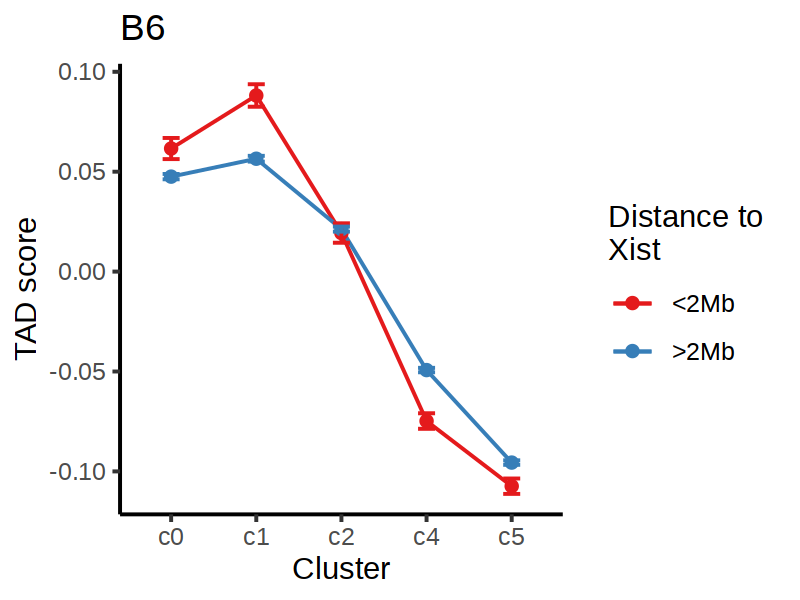

In [14]:
options(repr.plot.width=4,repr.plot.height=3,repr.plot.res=200)
test_plot %>%
    mutate(plot_cluster = paste0("c",plot_cluster)) %>%
    ggplot(aes(x=plot_cluster, y=mean, group=type, color=type)) + 
    geom_line(size = 0.5) +
    geom_point()+
    geom_errorbar(aes(ymin=mean-se, ymax=mean+se), width=.4,
                position=position_dodge(0))   + ylab('TAD score') + xlab("Cluster")+ scale_colour_manual(values=c('#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00'),name = "Distance to \nXist") +
    theme_classic() + ggtitle("B6")

In [15]:
test_plot2 <- score_b6 %>% left_join(my_tad %>% select(index, dist) %>% mutate(index = as.character(index))) %>% pivot_longer(!c("index", "dist"), names_to = "cellname") %>% left_join(metadata %>% select(cellname, plot_cluster)) %>% 
    group_by(plot_cluster, index, dist) %>% summarise(value = median(value)) %>% filter(plot_cluster %in% c(1,2)) %>% mutate(plot_cluster = paste0('c',plot_cluster)) %>% 
    pivot_wider(values_from = 'value', names_from = 'plot_cluster') %>% mutate(ratio = (c1-c2)/c1) %>%
    mutate(type = ifelse(dist < 100, "<2Mb",">2Mb")) %>% 
    mutate(type = factor(type, levels = c("<2Mb",">2Mb"))) %>%
    group_by(type) %>% summarise(mean_ratio = mean(ratio), sd_ratio = sd(ratio), n = n()) %>% mutate(se = sd_ratio/sqrt(n))

Joining with `by = join_by(index)`
Joining with `by = join_by(cellname)`
`summarise()` has grouped output by 'plot_cluster', 'index'. You can override using the `.groups` argument.


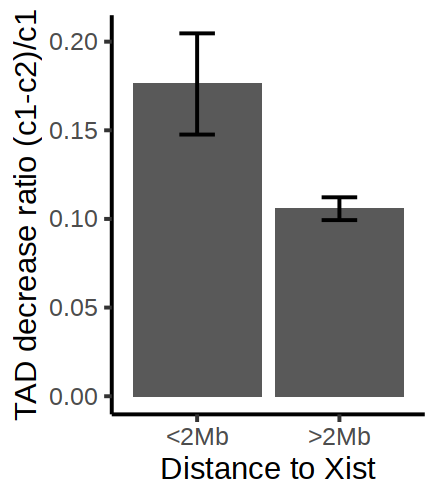

In [16]:
options(repr.plot.width=2.2,repr.plot.height=2.5,repr.plot.res=200)
test_plot2 %>% ggplot(aes(x = type, y = mean_ratio)) +
  geom_bar(stat = "identity", position = "dodge") +
  geom_errorbar(aes(ymin = mean_ratio - se, ymax = mean_ratio + se),
                position = position_dodge(0.9), width = 0.25) +
  theme_classic() + scale_fill_manual(values=c('#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33'),name = "") + ylab('TAD decrease ratio (c1-c2)/c1') + xlab("Distance to Xist")

In [17]:
test_plot <- score_cast %>% left_join(my_tad %>% select(index, dist) %>% mutate(index = as.character(index))) %>% pivot_longer(!c("index", "dist"), names_to = "cellname") %>% left_join(metadata %>% select(cellname, plot_cluster)) %>% 
    mutate(type = ifelse(dist < 100, "<2Mb",">2Mb")) %>% 
    mutate(type = factor(type, levels = c("<2Mb",">2Mb"))) %>%
    group_by(type) %>% mutate(mean_value = mean(value), sd_value = sd(value)) %>% mutate(value = value-mean_value)

Joining with `by = join_by(index)`
Joining with `by = join_by(cellname)`


In [18]:
test_plot <- test_plot %>% filter(plot_cluster %in% c(0,1,2,3)) %>% group_by(plot_cluster, type) %>% summarise(mean = mean(value), sd = sd(value), n = n()) %>% mutate(se = sd/sqrt(n))

`summarise()` has grouped output by 'plot_cluster'. You can override using the `.groups` argument.


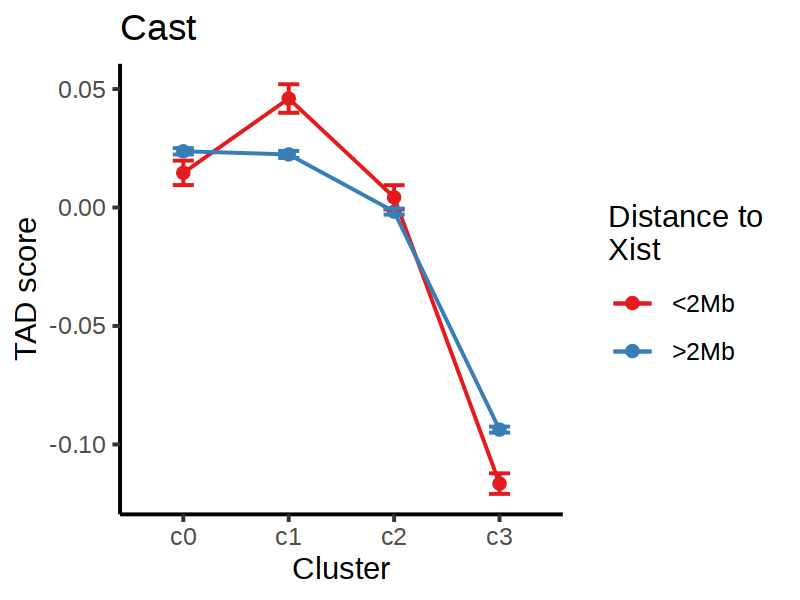

In [19]:
options(repr.plot.width=4,repr.plot.height=3,repr.plot.res=200)
test_plot %>%
    mutate(plot_cluster = paste0("c",plot_cluster)) %>%
    ggplot(aes(x=plot_cluster, y=mean, group=type, color=type)) + 
    geom_line(size = 0.5) +
    geom_point()+
    geom_errorbar(aes(ymin=mean-se, ymax=mean+se), width=.4,
                position=position_dodge(0))   + ylab('TAD score') + xlab("Cluster")+ scale_colour_manual(values=c('#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00'),name = "Distance to \nXist") +
    theme_classic() + ggtitle("Cast")

Joining with `by = join_by(index)`
Joining with `by = join_by(cellname)`
`summarise()` has grouped output by 'plot_cluster', 'index'. You can override using the `.groups` argument.


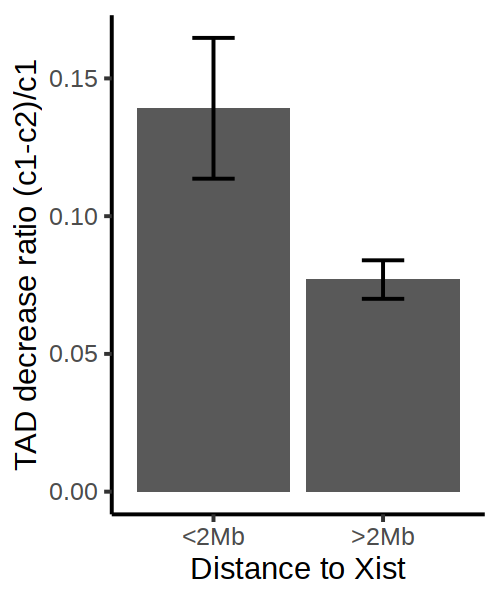

In [20]:
options(repr.plot.width=2.5,repr.plot.height=3,repr.plot.res=200)

test_plot2 <- score_cast %>% left_join(my_tad %>% select(index, dist) %>% mutate(index = as.character(index))) %>% pivot_longer(!c("index", "dist"), names_to = "cellname") %>% left_join(metadata %>% select(cellname, plot_cluster)) %>% 
    group_by(plot_cluster, index, dist) %>% summarise(value = median(value)) %>% filter(plot_cluster %in% c(1,2)) %>% mutate(plot_cluster = paste0('c',plot_cluster)) %>% 
    pivot_wider(values_from = 'value', names_from = 'plot_cluster') %>% mutate(ratio = (c1-c2)/c1) %>%
    mutate(type = ifelse(dist < 100, "<2Mb",">2Mb")) %>% 
    mutate(type = factor(type, levels = c("<2Mb",">2Mb"))) %>%
    group_by(type) %>% summarise(mean_ratio = mean(ratio), sd_ratio = sd(ratio), n = n()) %>% mutate(se = sd_ratio/sqrt(n))

test_plot2 %>% ggplot(aes(x = type, y = mean_ratio)) +
  geom_bar(stat = "identity", position = "dodge") +
  geom_errorbar(aes(ymin = mean_ratio - se, ymax = mean_ratio + se),
                position = position_dodge(0.9), width = 0.25) +
  theme_classic() + scale_fill_manual(values=c('#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33'),name = "") + ylab('TAD decrease ratio (c1-c2)/c1') + xlab("Distance to Xist")

# Plot

In [122]:
plot_b6 <- score_b6 %>% left_join(my_tad %>% select(index, dist) %>% mutate(index = as.character(index))) %>% pivot_longer(!c("index", "dist"), names_to = "cellname") %>% left_join(metadata %>% select(cellname, plot_cluster)) %>% 
    group_by(plot_cluster, index, dist) %>% summarise(value = median(value)) %>% filter(plot_cluster %in% c(1,2)) %>% mutate(plot_cluster = paste0('c',plot_cluster)) %>% 
    pivot_wider(values_from = 'value', names_from = 'plot_cluster') %>% mutate(ratio = (c1-c2)/c1) %>%
    mutate(type = ifelse(dist < 100,"<2Mb",ifelse(dist < 2500, "2-50Mb", ">50Mb"))) %>% 
    mutate(type = factor(type, levels = c("<2Mb","2-50Mb",">50Mb"))) %>%
    group_by(type) %>% summarise(mean_ratio = mean(ratio), sd_ratio = sd(ratio), n = n()) %>% mutate(se = sd_ratio/sqrt(n)) %>% mutate(allele = "B6")

plot_cast <- score_cast %>% left_join(my_tad %>% select(index, dist) %>% mutate(index = as.character(index))) %>% pivot_longer(!c("index", "dist"), names_to = "cellname") %>% left_join(metadata %>% select(cellname, plot_cluster)) %>% 
    group_by(plot_cluster, index, dist) %>% summarise(value = median(value)) %>% filter(plot_cluster %in% c(1,2)) %>% mutate(plot_cluster = paste0('c',plot_cluster)) %>% 
    pivot_wider(values_from = 'value', names_from = 'plot_cluster') %>% mutate(ratio = (c1-c2)/c1) %>%
    mutate(type = ifelse(dist < 100,"<2Mb",ifelse(dist < 2500, "2-50Mb", ">50Mb"))) %>% 
    mutate(type = factor(type, levels = c("<2Mb","2-50Mb",">50Mb"))) %>%
    group_by(type) %>% summarise(mean_ratio = mean(ratio), sd_ratio = sd(ratio), n = n()) %>% mutate(se = sd_ratio/sqrt(n)) %>% mutate(allele = "Cast")

Joining with `by = join_by(index)`
Joining with `by = join_by(cellname)`
`summarise()` has grouped output by 'plot_cluster', 'index'. You can override using the `.groups` argument.
Joining with `by = join_by(index)`
Joining with `by = join_by(cellname)`
`summarise()` has grouped output by 'plot_cluster', 'index'. You can override using the `.groups` argument.


In [123]:
score_b6 %>% left_join(my_tad %>% select(index, dist) %>% mutate(index = as.character(index))) %>% pivot_longer(!c("index", "dist"), names_to = "cellname") %>% left_join(metadata %>% select(cellname, plot_cluster)) %>% 
    group_by(plot_cluster, index, dist) %>% summarise(value = median(value)) %>% filter(plot_cluster %in% c(1,2)) %>% mutate(plot_cluster = paste0('c',plot_cluster)) %>% 
    pivot_wider(values_from = 'value', names_from = 'plot_cluster') %>% mutate(ratio = (c1-c2)/c1) %>%
    mutate(type = ifelse(dist < 100,"<2Mb",ifelse(dist < 2500, "2-50Mb", ">50Mb"))) %>% 
    mutate(type = factor(type, levels = c("<2Mb","2-50Mb",">50Mb"))) %>%
    group_by(type) %>% summarise(n = n())

Joining with `by = join_by(index)`
Joining with `by = join_by(cellname)`
`summarise()` has grouped output by 'plot_cluster', 'index'. You can override using the `.groups` argument.


type,n
<fct>,<int>
<2Mb,7
2-50Mb,64
>50Mb,39


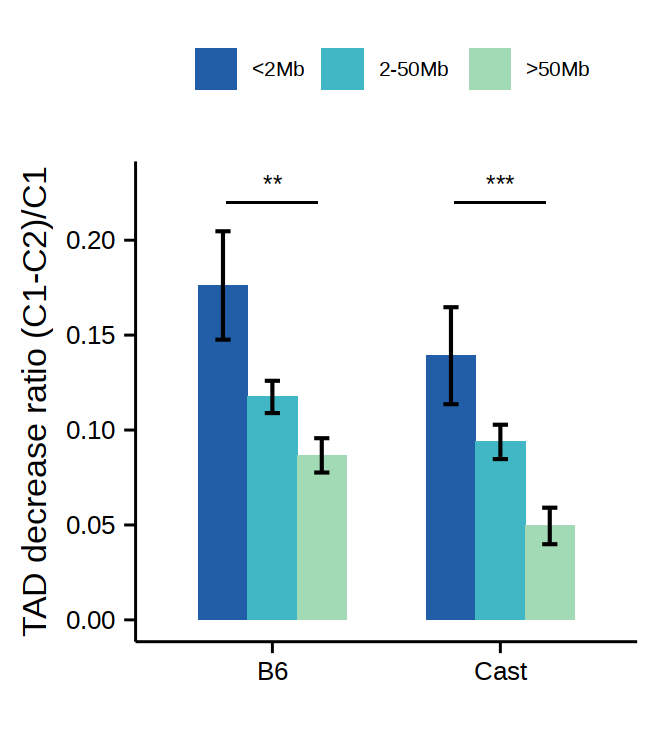

In [126]:
options(repr.plot.width=2.2,repr.plot.height=2.5,repr.plot.res=300)
rbind(plot_b6, plot_cast) %>% ggplot(aes(x = allele, y = mean_ratio, fill = type)) +
  geom_bar(stat = "identity", position = "dodge", width = 0.65) +
  geom_errorbar(aes(ymin = mean_ratio - se, ymax = mean_ratio + se),
                position = position_dodge(0.65), width = 0.2, linewidth = 0.35) +
    scale_fill_manual(values = rev(c('#ffffcc','#a1dab4','#41b6c4','#225ea8')), name = "") +
      theme_classic()  + ylab('TAD decrease ratio (C1-C2)/C1') + xlab("") +
      theme(legend.position = "top",
      text = element_text(family="Arial", size=6),
      panel.border = element_blank(),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.background = element_blank(),
      axis.line = element_line(color="black", linewidth = 0.25),
      axis.ticks = element_line(color="black", linewidth = 0.25),
      axis.text = element_text(color="black",size=6),
      legend.key = element_rect(colour = NA),
      legend.key.width = unit(0.4, "cm"),
      legend.key.height = unit(0.4, "cm"),
      axis.title=element_text(color="black",size=8,face="plain"),
  )+geom_segment(aes(x = 0.8, xend = 1.2, y = 0.22, yend = 0.22), color = "black", linewidth = 0.25) + # 添加线条
  annotate("text", x = 1, y = 0.23, label = "**", size = 2)+
    geom_segment(aes(x = 1.8, xend = 2.2, y = 0.22, yend = 0.22), color = "black", linewidth = 0.25) + # 添加线条
  annotate("text", x = 2, y = 0.23, label = "***", size = 2)
ggsave("/share/Data/hxie/project/202209/esc_xwliu/figures_0827/fig3/fig3_tad_dist_bar.svg", width = 2.2, height = 2.5, units = "in", dpi = 300)

In [108]:
score_b6 %>% left_join(my_tad %>% select(index, dist) %>% mutate(index = as.character(index))) %>% pivot_longer(!c("index", "dist"), names_to = "cellname") %>% left_join(metadata %>% select(cellname, plot_cluster)) %>% 
    group_by(plot_cluster, index, dist) %>% summarise(value = median(value)) %>% filter(plot_cluster %in% c(1,2)) %>% mutate(plot_cluster = paste0('c',plot_cluster)) %>%
    pivot_wider(values_from = 'value', names_from = 'plot_cluster') %>% mutate(ratio = (c1-c2)/c1) %>%
    mutate(type = ifelse(dist < 100,"<2Mb",ifelse(dist < 2500, "<50Mb", ">50Mb"))) %>% 
    mutate(type = factor(type, levels = c("<2Mb","<50Mb",">50Mb"))) %>% aov(ratio ~ type, data = .) %>% summary

Joining with `by = join_by(index)`
Joining with `by = join_by(cellname)`
`summarise()` has grouped output by 'plot_cluster', 'index'. You can override using the `.groups` argument.


             Df Sum Sq  Mean Sq F value  Pr(>F)   
type          2 0.0554 0.027713   6.652 0.00189 **
Residuals   107 0.4458 0.004166                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [112]:
score_cast %>% left_join(my_tad %>% select(index, dist) %>% mutate(index = as.character(index))) %>% pivot_longer(!c("index", "dist"), names_to = "cellname") %>% left_join(metadata %>% select(cellname, plot_cluster)) %>% 
    group_by(plot_cluster, index, dist) %>% summarise(value = median(value)) %>% filter(plot_cluster %in% c(1,2)) %>% mutate(plot_cluster = paste0('c',plot_cluster)) %>%
    pivot_wider(values_from = 'value', names_from = 'plot_cluster') %>% mutate(ratio = (c1-c2)/c1) %>%
    mutate(type = ifelse(dist < 100,"<2Mb",ifelse(dist < 2500, "<50Mb", ">50Mb"))) %>% 
    mutate(type = factor(type, levels = c("<2Mb","<50Mb",">50Mb"))) %>% aov(ratio ~ type, data = .) %>% summary

Joining with `by = join_by(index)`
Joining with `by = join_by(cellname)`
`summarise()` has grouped output by 'plot_cluster', 'index'. You can override using the `.groups` argument.


             Df Sum Sq Mean Sq F value   Pr(>F)    
type          2 0.0728 0.03641    7.88 0.000642 ***
Residuals   107 0.4944 0.00462                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

# single cell pileup score

In [4]:
setwd("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/TAD/version_0912")

In [5]:
pileup_score <- read_csv("pileup_raw_score.csv") %>% rename(cellname = `...1`)

New names:
* `` -> `...1`
Rows: 904 Columns: 3
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (1): ...1
dbl (2): pat_score, mat_score

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


Joining with `by = join_by(cellname)`
`summarise()` has grouped output by 'plot_cluster'. You can override using the
`.groups` argument.
Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


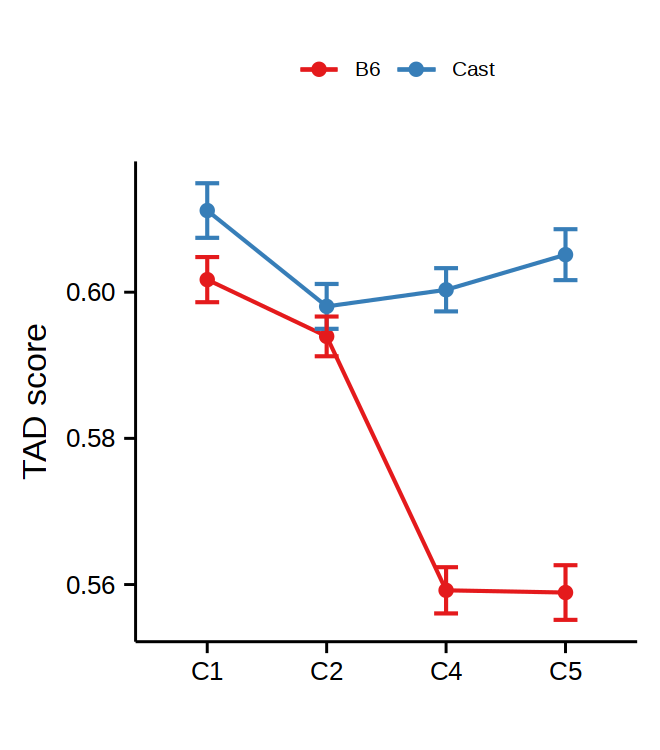

In [9]:
options(repr.plot.width=2.2,repr.plot.height=2.5,repr.plot.res=300)

pileup_score %>% left_join(metadata %>% select(cellname, plot_cluster)) %>% 
    pivot_longer(!c("cellname","plot_cluster"), names_to = "allele", values_to = "score") %>%
    group_by(plot_cluster, allele) %>% summarise(mean = mean(score), sd = sd(score), n = n(), se = sd/sqrt(n)) %>%
    mutate(allele = ifelse(allele == "mat_score", "Cast", "B6")) %>%
    filter(!plot_cluster %in% c(0,3))%>%
    mutate(plot_cluster = paste0("C", plot_cluster)) %>%
    ggplot(aes(x=plot_cluster, y=mean, group=allele, color=allele)) + 
    geom_line(size = 0.35) +
    geom_point(size = 0.85)+
    geom_errorbar(aes(ymin=mean-se, ymax=mean+se), width=.4,linewidth = 0.35,
                position=position_dodge(0))   + ylab('TAD score') + xlab("Cluster")+ scale_colour_manual(values=c('#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00'),name = "") +
    theme_classic() +
          theme(legend.position = "top",
      text = element_text(family="Arial", size=6),
      panel.border = element_blank(),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.background = element_blank(),
      axis.line = element_line(color="black", linewidth = 0.25),
      axis.ticks = element_line(color="black", linewidth = 0.25),
      axis.text = element_text(color="black",size=6),
      legend.key = element_rect(colour = NA),
      legend.key.width = unit(0.4, "cm"),
      legend.key.height = unit(0.4, "cm"),
      axis.title=element_text(color="black",size=8,face="plain"),
  ) + xlab("") 
ggsave("figures_raw_score/pileup_curve_revert_B6.svg", width = 2.2, height = 2.5, units = "in", dpi = 300)

In [10]:
pileup_score %>% left_join(metadata %>% select(cellname, plot_cluster)) %>% 
    pivot_longer(!c("cellname","plot_cluster"), names_to = "allele", values_to = "score") %>%
    group_by(plot_cluster, allele) %>% summarise(mean = mean(score), sd = sd(score), n = n(), se = sd/sqrt(n)) %>%
    mutate(allele = ifelse(allele == "mat_score", "Cast", "B6")) %>%
    filter(!plot_cluster %in% c(0,3))%>%
    mutate(plot_cluster = paste0("C", plot_cluster))

Joining with `by = join_by(cellname)`


`summarise()` has grouped output by 'plot_cluster'. You can override using the
`.groups` argument.


plot_cluster,allele,mean,sd,n,se
<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>
C1,Cast,0.6111769,0.04176752,125,0.003735800
C1,B6,0.6017198,0.03451580,125,0.003087187
C2,Cast,0.5980582,0.04015183,171,0.003070487
C2,B6,0.5939558,0.03555522,171,0.002718976
C4,Cast,0.6003320,0.04044482,187,0.002957618
C4,B6,0.5592070,0.04325835,187,0.003163364
C5,Cast,0.6051374,0.04120062,140,0.003482088
C5,B6,0.5589029,0.04425023,140,0.003739827


Joining with `by = join_by(cellname)`
`summarise()` has grouped output by 'plot_cluster'. You can override using the
`.groups` argument.


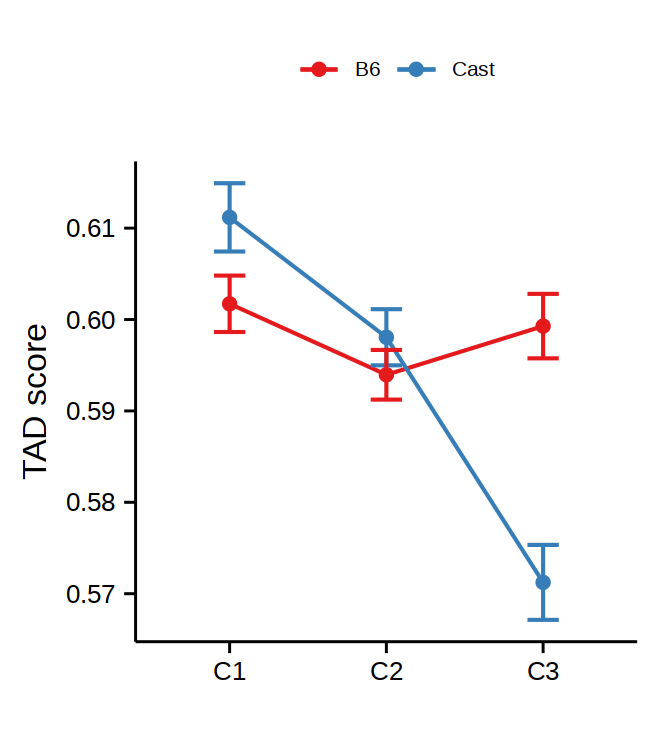

In [11]:
options(repr.plot.width=2.2,repr.plot.height=2.5,repr.plot.res=300)

pileup_score %>% left_join(metadata %>% select(cellname, plot_cluster)) %>% 
    pivot_longer(!c("cellname","plot_cluster"), names_to = "allele", values_to = "score") %>%
    group_by(plot_cluster, allele) %>% summarise(mean = mean(score), sd = sd(score), n = n(), se = sd/sqrt(n)) %>%
    mutate(allele = ifelse(allele == "mat_score", "Cast", "B6")) %>%
    filter(!plot_cluster %in% c(0,4,5))%>%
    mutate(plot_cluster = paste0("C", plot_cluster)) %>%
    ggplot(aes(x=plot_cluster, y=mean, group=allele, color=allele)) + 
    geom_line(size = 0.35) +
    geom_point(size = 0.85)+
    geom_errorbar(aes(ymin=mean-se, ymax=mean+se), width=.4,linewidth = 0.35,
                position=position_dodge(0))   + ylab('TAD score') + xlab("Cluster")+ scale_colour_manual(values=c('#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00'),name = "") +
    theme_classic() +
          theme(legend.position = "top",
      text = element_text(family="Arial", size=6),
      panel.border = element_blank(),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.background = element_blank(),
      axis.line = element_line(color="black", linewidth = 0.25),
      axis.ticks = element_line(color="black", linewidth = 0.25),
      axis.text = element_text(color="black",size=6),
      legend.key = element_rect(colour = NA),
      legend.key.width = unit(0.4, "cm"),
      legend.key.height = unit(0.4, "cm"),
      axis.title=element_text(color="black",size=8,face="plain"),
  ) + xlab("") 
ggsave("figures_raw_score/pileup_curve_revert_Cast.svg", width = 2.2, height = 2.5, units = "in", dpi = 300)

# same cell

Joining with `by = join_by(cellname)`


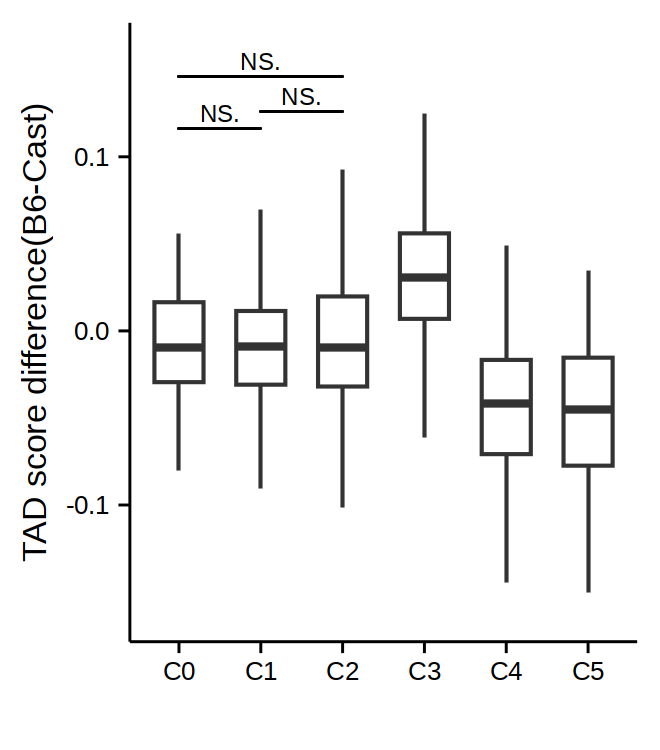

In [23]:
pileup_score %>% mutate(diff = pat_score-mat_score) %>% left_join(metadata %>% select(cellname, plot_cluster)) %>% 
    mutate(plot_cluster = paste0("C",plot_cluster)) %>%
    ggplot(aes(x = plot_cluster, y = diff)) + 
    geom_boxplot(outlier.shape = NA, width = 0.6, linewidth = 0.35, position = position_dodge(0.75)) +
    xlab("") + ylab("TAD score difference(B6-Cast)") +
    theme(legend.position = "top",
      text = element_text(family="Arial", size=6),
      panel.border = element_blank(),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.background = element_blank(),
      axis.line = element_line(color="black", linewidth = 0.25),
      axis.ticks = element_line(color="black", linewidth = 0.25),
      axis.text = element_text(color="black",size=6),
      legend.key = element_rect(colour = NA),
      legend.key.width = unit(0.3, "cm"),
      legend.key.height = unit(0.4, "cm"),
      axis.title=element_text(color="black",size=8,face="plain"),
  ) +
  geom_signif(comparisons = list(c("C0","C1"), c("C1","C2"), c("C0","C2")),
              y_position = c(0.1,0.11,0.13),
              map_signif_level = TRUE, tip_length = 0,size = 0.25, color = 'black', textsize = 2)
ggsave("figures_raw_score/difference_in_tad_score.svg", width = 2.2, height = 2.5, units = "in", dpi = 300)